In [246]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

from dataset import *

# This is a hack to be able to import modules in parent directory
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)


In [247]:
datasets = {
            'amazon-google': deepmatcher_structured_amazon_google,
            'dblp-acm': deepmatcher_structured_dblp_acm,
            'dblp-googlescholar': deepmatcher_structured_dblp_google_scholar,
            'itunes-amazon': deepmatcher_structured_itunes_amazon,
            'walmart-amazon': deepmatcher_structured_walmart_amazon,
            'abt-buy': deepmatcher_textual_abt_buy,
}

In [248]:
def plot(folder='out', experiments=[0,1,3,5,6], x='labeled_instances', y='test_f1', show_max=False, min_labeled=200):
    exps = [f'exp{nr}' for nr in experiments]
    data = {dataset: {} for dataset in datasets}
    max_val = {}
    for filename in sorted(glob(f'{folder}/out/**/*.csv', recursive=True)):
        if 'results' in filename:
            df = pd.read_csv(filename)
            dataset = filename.split('/')[-2].lower()
            for exp in exps:
                if exp in filename and exp == 'exp0':
                    max_val[dataset] = df.loc[:, y].iloc[-1]
                    print(max_val[dataset])
                    data[dataset][exp] = df.loc[df['labeled_instances'] >= min_labeled, :].iloc[:-1]
                    
                elif exp in filename:
                    dataset = filename.split('/')[4].lower()
                    df = pd.read_csv(filename)
                    data[dataset][exp] = df.loc[df['labeled_instances'] >= min_labeled, :]
    
    f(data, x, y, max_val if show_max else None)

In [249]:
def f(data, x, y, max_val):
    for dataset in sorted(data.keys()):
        print('Dataset:', dataset)
        plt.figure(figsize=(15, 4), dpi=80, facecolor='w', edgecolor='k') # set size of plot
        legends = []
        legend_trans = {
            'exp0': 'Random baseline',
            'exp1': 'Transformer al',
            'exp3': 'ML-AL transformer',
            'exp5': 'Uncertainity',
            'exp6': 'Kasi proper (half labeled instances)'
        }
        scores = data[dataset]
        
        for exp in sorted(scores.keys()):
            plt.plot(scores[exp][x], scores[exp][y])
            legends.append(legend_trans[exp])
        
        if max_val and dataset in max_val:
            plt.axhline(y=max_val[dataset], color='r')
            legends.append(f'max')

        #plt.xticks(scores[list(scores.keys())[-1]][x])  # set values of points on x axis
        plt.margins(0.01) # set margins to 0.01
        
        plt.legend(legends, loc=4)
        title = dataset.split('/')[-1]
        plt.title(title)
        plt.xlabel('# labeled training data');

    
        plt.savefig(f'{dataset}.pdf', format='pdf', bbox_inches='tight')

0.708
0.988
0.954
0.865
Dataset: abt-buy
Dataset: amazon-google
Dataset: dblp-acm
Dataset: dblp-googlescholar
Dataset: itunes-amazon
Dataset: walmart-amazon


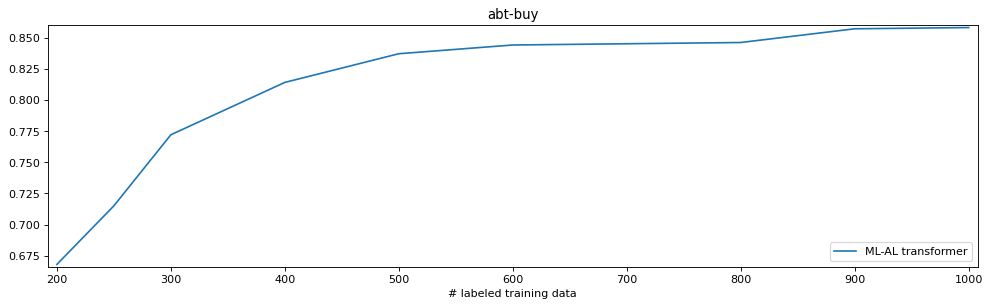

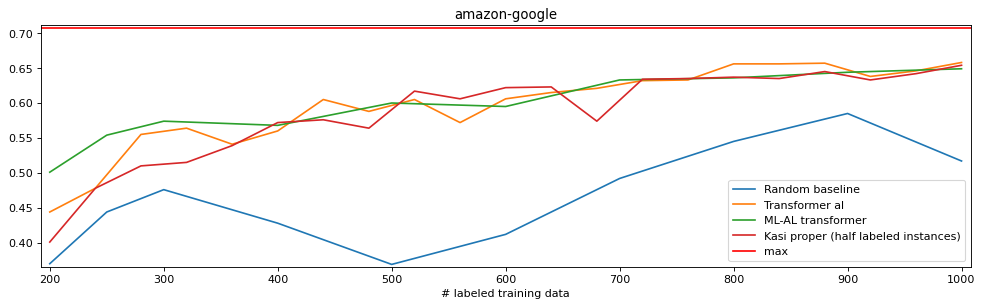

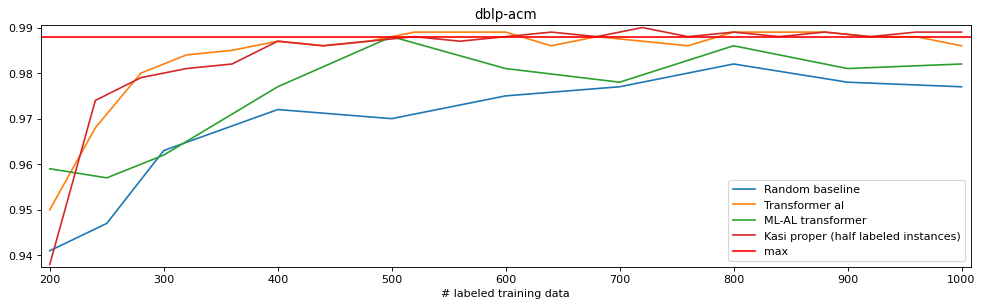

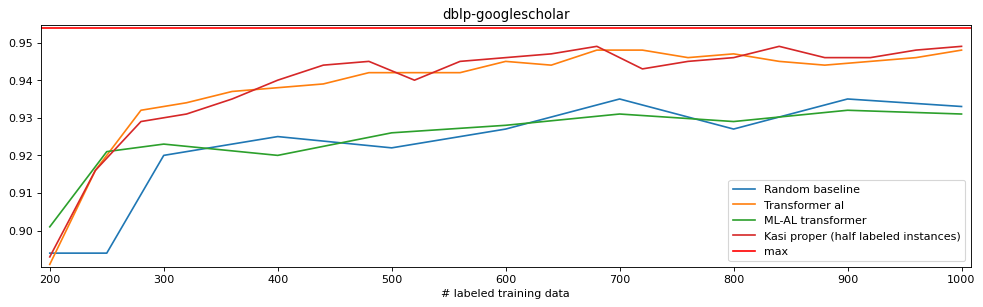

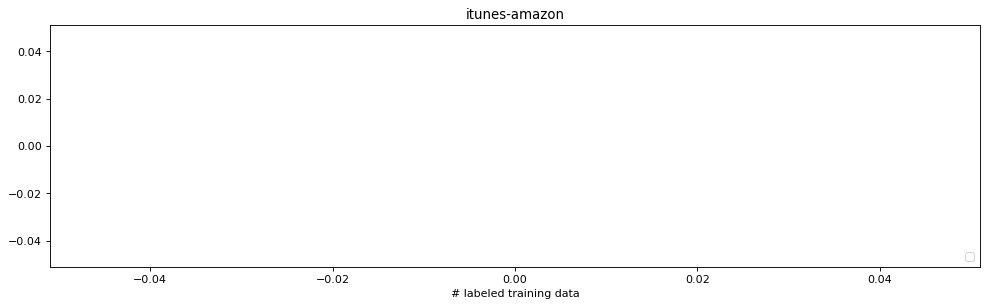

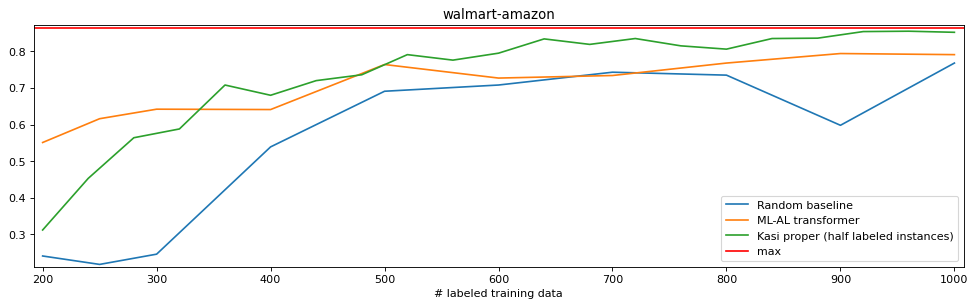

In [250]:
plot(folder='roberta-2603', show_max=True, min_labeled=)